# Model NEATM 余亮亮 修改 $\alpha, \phi$
$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$
$p_v=\frac{A_B}{q}$
$q_s=\frac{F_{sun}}{d^2}$
$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$
$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$
$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$


### test Fortran

In [53]:
import os
d = 1.12554
delta = 1.14078
alpha = 0
D = 40.0
lamda = 12.0
eta = 1.23
A = 0.0505
para = str(d)+' '+str(delta)+' '+str(alpha)+' '+str(D)+' '+str(lamda)+' '+str(eta)+' '+str(A)
exe ='./a.out '+' '+para 
ret = os.system(exe)
f = os.popen(exe)
print("hello=",f.readline())
f.close()
#print('./a.out '+' '+para)


   8.8757144855184248E-005
hello=    8.8757144855184248E-005



# MCMC_NEATM

## define const & import

In [54]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import pandas as pd
from tqdm import tqdm
import os
#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9              #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
eta_guess = [1.2,0.7]
D_guess = [400,200000]
logf_guess = [1,0.1,1]
eta_piror = [0.5,2.8]
D_piror = [0,2500000]
Hv = 23.7
G = 0.15
Ndd = 15
lamdai = [12,22]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

In [55]:
#ret = os.popen('./a.out 2 6')
#a1 = ret.readlines()
def Model_neatm_hhq(theta,x,lamda):
    eta,D = theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    #print("neatm ",delta)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        ret = os.system('./neatm '+str(eta)+' '+str(D)+' '+str(delta[i])+' '+str(d[i])+' '+str(alpha[i])+' '+str(lamda1)+' '+str(A)+' '+str(Ndd))
        #print('./neatm '+str(eta)+' '+str(D)+' '+str(delta[i])+' '+str(d[i])+' '+str(alpha[i])+' '+str(lamda1)+' '+str(A))
        flux[i] = ret
    for i in range(int(nn/2),nn):
        ret = os.system('./neatm '+str(eta)+' '+str(D)+' '+str(delta[i])+' '+str(d[i])+' '+str(alpha[i])+' '+str(lamda2)+' '+str(A)+' '+str(Ndd))
        flux[i] = ret
        #print("neatm",i,'=',delta[i])
    #print('2',delta)
    return flux

In [56]:
#ret = os.popen('./a.out 2 6')
def Model_neatm_fort(theta,x,lamda):
    eta,D = theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    #print("neatm ",delta)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        para = str(d[i])+' '+str(delta[i])+' '+str(alpha[i])+' '+str(D)+' '+str(lamda1)+' '+str(eta)+' '+str(A)
        exe ='./a.out '+' '+para 
        f = os.popen(exe)
        flux[i] = f.readline()
        f.close()
    for i in range(int(nn/2),nn):
        para = str(d[i])+' '+str(delta[i])+' '+str(alpha[i])+' '+str(D)+' '+str(lamda2)+' '+str(eta)+' '+str(A)
        exe ='./a.out '+' '+para 
        f = os.popen(exe)
        flux[i] = f.readline()
        f.close()
    return flux

In [57]:
#constants---------------------------------------------------------------------------
#emissivity:
epsi = 0.9
#stefan-boltzman:
sigmas = 5.67*10**(-8)
#solar constant:
f_solar = 1367.5
#planck constant:
h = 6.62607015 * 10 ** (-34)
#speed of light
c = 3.0 * 10 ** 8 
#boltzmann constant
kb = 1.380649 * 10 ** (-23)
#astronomical unit in unit of meter
au = 1.496 * 10 ** 11
def neatm_jhx(Ndd,dast,dao,alpha,Dia,wlenth,yita,A):
    #dast: distance from asteroid to Sun :d
    #dobs: distance from observer to Sun  :dd
    #dao:  distance from asteroid to observer :delta
    #alpha: solar phase
    #dia: diameter of asteroid
    #wlenth: wavelength
    #yita: beaming parameter
    #A: bond albedo
	
	T_ss = ((1 - A) * f_solar / epsi / yita / sigmas / dast ** 2) ** 0.25
	Nd = int(Ndd)
	phi = np.zeros((Nd-1,1))
	theta = np.zeros((Nd-1,1))
	for i in range(0,Nd-1):#phi , theta is the angle from subsolar point
			phi[i] = -pi/2.0 + i * pi / Nd
			theta[i] = -pi/2.0 + i * pi / Nd
	nj = np.floor(((alpha - pi / 2.0) + pi / 2.0) / (pi / Nd)) 
	dphi, dtheta = pi/Nd,pi/Nd
	ss = dphi*dtheta#dtheta*dphi
	wlenth = wlenth * 10 ** (-6)
	temp = np.zeros((len(phi),len(theta)))
	flux = 0.0
	flux_con = epsi * Dia ** 2 * pi  * h * c ** 2  / (wlenth ** 5)
	for j in range(0,len(phi)):
		for k in range(int(nj),len(theta)):
			temp[j,k] = T_ss * np.cos(theta[k]) ** 0.25 * np.cos(phi[j]) ** 0.25
			flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
	return flux
def Model_neatm_jhx(theta,x,lamda):
    eta,D =theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    nn = len(delta)
    flux = np.zeros(nn)
    for i in range(0,int(nn/2)):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda1,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
    for i in range(int(nn/2),nn):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda2,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
        
    #print('hello',flux)
    return flux

## read data file

处理原始数据 将坐标垂直叠加，方便直接计算12，22微米的流量

In [58]:
namelist = ['2003MA3','2010CO1','2010DG77','2010EX11','2010FC81','2010FH81','2010GS7','2010JN71','2010KX7','2010PW58','2010XP69','2019DD2']
name = namelist[4].lower()
name = '2010fe7'
name

'2010fe7'

计算delta d 看看对不对

In [59]:
obsec = np.loadtxt(f'newepoch_{name}.txt')
#print(obsec)
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#earth-sun
print(delta_N)
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
alpha_N/pi*180

[0.32425158 0.32538916 0.32652899 0.32767106 0.32824348 0.32881538
 0.32881648 0.32938894 0.32996305 0.33053663 0.33168659 0.3328388
 0.33399327 0.33399438 0.32425158 0.32538916 0.32652899 0.32767106
 0.32824348 0.32881538 0.32881648 0.32938894 0.32996305 0.33053663
 0.33168659 0.3328388  0.33399327 0.33399438]


array([7.080265  , 7.16804377, 7.25626141, 7.34488418, 7.38937978,
       7.43388   , 7.4339656 , 7.47855145, 7.52330433, 7.56805037,
       7.65784898, 7.74792046, 7.83823933, 7.83832614, 7.080265  ,
       7.16804377, 7.25626141, 7.34488418, 7.38937978, 7.43388   ,
       7.4339656 , 7.47855145, 7.52330433, 7.56805037, 7.65784898,
       7.74792046, 7.83823933, 7.83832614])

[0.58843722 0.58318882 0.57799176 0.57284552 0.57028886 0.56774957
 0.5677447  0.56521784 0.56269856 0.56019638 0.55522391 0.55029993
 0.54542395 0.54541929 0.71702897 0.71110071 0.70522674 0.69940655
 0.69651372 0.69363963 0.69363412 0.69077323 0.68792001 0.68508527
 0.67944932 0.67386486 0.6683314  0.66832611]


/tmp/ipykernel_142075/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_142075/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


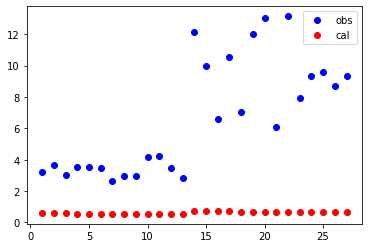

In [60]:

obsec = np.loadtxt(f'newepoch_{name}.txt')
obsdat = np.loadtxt(f'w34_{name}.txt')

#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
#print('ast-sun',d_N)

#ast-earth
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#print('ast-earth',delta_N)

#earth-sun
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
#print('earth-sun',dd_N)

#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
#print("alpha",alpha_N/pi*180,'\n')
y = obsdat
nt = np.arange(len(d_N))
theta = [1.5,45]
flux = Model_neatm_jhx(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
x = (delta_N,d_N,alpha_N)
yerr = 0.1*y
#plt.plot(nt,flux,label = 'hhq')
#plt.plot(nt,flux,label = 'hhq')
print(flux)
plt.plot(nt[1:60],obsdat[1:60],'bo',label = 'obs')
plt.plot(nt[1:60],flux[1:60],'ro',label = 'cal')
#plt.plot(nt[0:len(d_N)],alpha_N[0:len(d_N)],'go',label = 'alpha')
#print(flux[0:len(d_N)])
plt.legend()
lenthi = [8,30,200]
dddd = (lenthi[1]-lenthi[0])/lenthi[2]
lenth = lenthi[0]
D = 136
pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
q = 0.29+0.684*G
A = q*pv
flamda = []
nlenth  = []
for i in range(lenthi[2]):
    lenth = lenth+dddd
    nlenth.append(lenth)
    flamda.append((neatm_jhx(Ndd,d_N[1],delta_N[1],alpha_N[1],D,lenth,1.2,A)))
#plt.plot(nlenth,flamda,label = 'cal')  


## define MCMC_function

In [61]:
#initial
eta_gs = 1.2
D_gs = 150
eta_gss = [0.5,5]
D_gss = [1,300]

In [62]:
#MCMC Function
def log_likelihood(theta, x, y, yerr):
    eta,D= theta
    model = Model_neatm_jhx(theta,x,lamdai)
    #model = eta*x[0]*100 + D
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
def log_prior(theta):
    eta,D = theta
    if eta_gss[0]< eta < eta_gss[1] and D_gss[0] < D < D_gss[1]:
        return 0.0
    return -np.inf
    #return 0
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
     #   print('hi','-inf')
        return -np.inf
    yy=lp + log_likelihood(theta, x, y, yerr)
    #print('hi',yy)
    return yy


In [63]:
#initial para guesses
eta = eta_gs
D = D_gs
theta = [eta, D]

In [64]:
import emcee
#initialize sampler
ndim, nwalkers = len(theta), 10
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
pos = [theta + 1e-6*np.random.randn(ndim) for i in range(nwalkers)]
#run mcmc
sampler.run_mcmc(pos, 1000, progress=True);

/tmp/ipykernel_142075/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
100%|██████████| 1000/1000 [18:43<00:00,  1.12s/it]


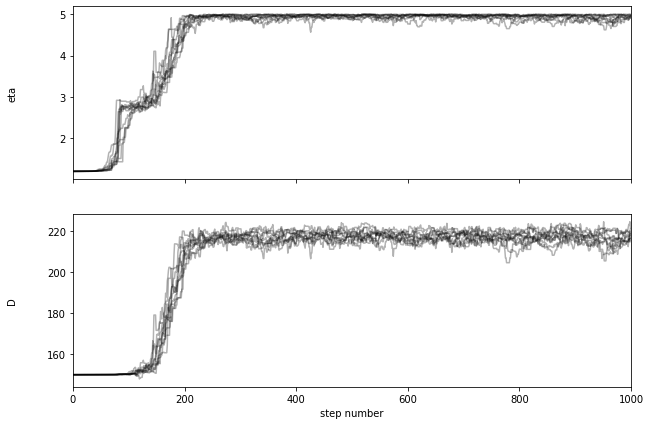

In [65]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["eta", "D"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");

(260, 2)


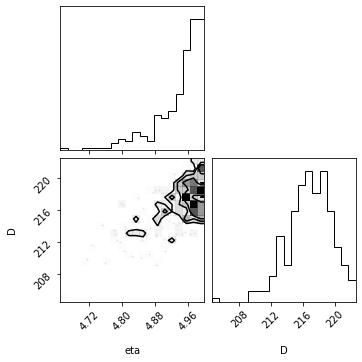

In [66]:
#--------------------------
flat_samples = sampler.get_chain(discard=600, thin=15, flat=True)
print(flat_samples.shape)
import corner
fig = corner.corner(
flat_samples, labels=labels, truths=[eta_gs, 103816]
);

In [67]:
from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #print(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))
print(Math(txt))
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
pv = (1329*pow(10,-Hv/5)/(D_fit*0.001))**2
print('eta_gs = ',eta_gs,'D_gs= ',D_gs,'pv=',pv)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>
eta_gs =  1.2 D_gs=  150 pv= 0.012427316321141031


eta_fit =  4.9583976651909465 D_fit=  216.93833593781096 pv =  0.012427316321141031
loss =  10.221014661722824


/tmp/ipykernel_142075/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_142075/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_142075/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_142075/4018011249.py:43: RuntimeWarning: overflow encountered in exp
 

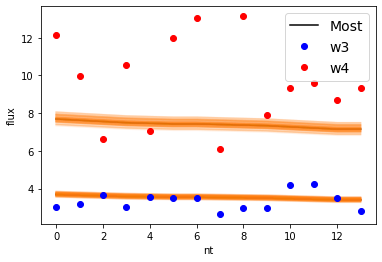

In [68]:
def loss(cal,y,yerr):
    nn = len(y)
    return sum(((cal-y)/yerr)**2)/nn
eta_low,eta_fit,eta_high = np.percentile(flat_samples[:, 0], [16, 50, 84])
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
print('eta_fit = ',eta_fit,'D_fit= ',D_fit,'pv = ',(1329*pow(10,-Hv/5)/(D_fit*0.001))**2)
theta = eta_fit,D_fit

leni = len(nt)
half = int(leni/2)
yt = Model_neatm_jhx(theta,x,lamdai)
print('loss = ',loss(yt,y,yt*0.1))
plt.plot(nt[0:half], yt[0:half],"k")
plt.plot(nt[0:half], yt[half:leni],"k", label="Most")

inds = np.random.randint(len(flat_samples), size=100)
#print(nt)
#print(len(flat_samples))

#print(nt[0:half])
#print(nt[half:leni])
for ind in inds:
    sample = flat_samples[ind]
    #print(ind,':',sample)
    plotmodel = Model_neatm_jhx(sample,x,lamdai)
    plt.plot(nt[0:half], plotmodel[0:half], "C1", alpha=0.1)
    plt.plot(nt[0:half], plotmodel[half:leni], "C1", alpha=0.1)
plt.plot(nt[0:half],y[0:half],'bo',label = 'w3')
plt.plot(nt[0:half],y[half:leni],'ro',label = 'w4')
#plt.errorbar(nt[0:half], y[0:half], yerr=yerr[0:half], fmt=".k", capsize=0)
#plt.errorbar(nt[0:half], y[half:leni], yerr=yerr[half:leni], fmt=".k", capsize=0)
plt.legend(fontsize=14)
plt.xlabel("nt")
plt.ylabel("flux");
